In [76]:
# import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

import mysql.connector

from config import Cfg as cfg

%matplotlib inline

## Races info

In [77]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM races;"
# execute the query and assign it to a pandas dataframe
df_races = pd.read_sql(query, con=cnx)

cnx.close()

### Some processing on the datasets

In [78]:
# -----------
# -- RACES --
# -----------

# keep only active races
df_races = df_races.loc[df_races['info'].dropna().index]


### what do we have left to work with?

In [79]:
print('-- Races dataset --')
print(f"  Number of active races: {len(df_races)}")

-- Races dataset --
  Number of active races: 160


### Load number of entrants

In [80]:
races_entrants_count = {}
with open("./../data/races/races-athletes-count.jl") as f:
    for line in f.readlines():
        data = json.loads(line.strip())
        if races_entrants_count.get(data['id']):
            races_entrants_count[data['id']].append(
                { "year": int(data['date'][:4]),
                  "entrants": data['count']
                }
            )
        else:
            races_entrants_count[data['id']] = [
                { "year": int(data['date'][:4]),
                  "entrants": data['count']
                }]

## Sinuosity of route

In [81]:
def get_angle_between(v1, v2, degrees=False):
    angle = np.math.atan2(np.linalg.det([v1, v2]), np.dot(v1, v2))
    if degrees:
        angle = np.degrees(angle)
    return angle

def get_successive_angles(x, y):
    x_diff = x[1:] - x[:-1]
    y_diff = y[1:] - y[:-1]
    angles = []
    for i in range(len(x_diff)-1):
        v1 = [x_diff[i], y_diff[i]]
        v2 = [x_diff[i+1], y_diff[i+1]]
        angles.append(np.abs(get_angle_between(v1, v2, degrees=True)))
    return np.array(angles)

In [103]:
# hash for swim types in db
swim_type = {
    'h': 'harbor',
    'o': 'ocean',
    'l': 'lake',
    'r': 'river'
}

# Constructs data with select features

In [83]:
races_final = df_races.loc[:, ['race', 'city', 'region']]

In [104]:
races_final['lat'] = 0
races_final['lon'] = 0
races_final['entrants_count_avg'] = 0
races_final['run_sinusoity'] = 0
races_final['run_distance'] = 0
races_final['run_elevationGain'] = 0
races_final['run_score'] = 0
races_final['bike_sinusoity'] = 0
races_final['bike_distance'] = 0
races_final['bike_elevationGain'] = 0
races_final['bike_score'] = 0
races_final['swim_distance'] = 0
races_final['swim_type'] = ''



year_threshold = 2014

for race in races_final.race:
    # avg number of race entrants
    mean_count = 0
    race_participation = races_entrants_count.get(race, 0)
    if not race_participation:
        # try with lowercase
        race_participation = races_entrants_count.get(race.lower(), 0)
    if race_participation:
        counts = np.array([y['entrants'] if y['year']>year_threshold else np.nan for y in race_participation]) 
        mean_count = np.nanmean(counts)
        
    # get lat/lon by averaging run points  
    run_map = json.loads(df_races.loc[df_races.race==race]['map'].values[0])['run']
    run_data = np.array(run_map['points'])
    lon = run_data[:, 0].mean()
    lat = run_data[:, 1].mean()
    # sinusoity of run route
    run_sinusoity = get_successive_angles(run_data[:, 0], run_data[:, 1]).mean()
    
    # sinusoity of bike route
    bike_map = json.loads(df_races.loc[df_races.race==race]['map'].values[0])['bike']
    bike_data = np.array(bike_map['points'])
    bike_sinusoity = get_successive_angles(bike_data[:, 0], bike_data[:, 1]).mean()
    
    # infos
    infos = json.loads(df_races.loc[df_races.race==race]['info'].values[0])
    
    races_final.loc[ 
        races_final.race == race, 
        ['lat', 
         'lon', 
         'entrants_count_avg',
         'run_sinusoity',
         'run_distance',
         'run_elevationGain',
         'run_score',
         'bike_sinusoity',
         'bike_distance',
         'bike_elevationGain',
         'bike_score',
         'swim_distance',
         'swim_type'
        ]] = [
         lat, 
         lon, 
         mean_count, 
         run_sinusoity,
         infos['run']['distance'],
         infos['run']['elevationGain'],
         infos['run']['score'],
         bike_sinusoity,
         infos['bike']['distance'],
         infos['bike']['elevationGain'],
         infos['bike']['score'],
         infos['swim']['distance'],
         swim_type[infos['swim']['type']]
        ]
    

/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


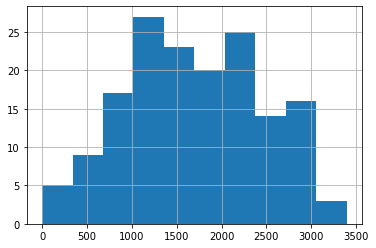

In [113]:
races_final.entrants_count_avg.hist()

In [112]:
# save data to use by all the geo API
races_final[['race', 'lat', 'lon']].to_csv("./../data/geo-data/races_lat_lon.csv", index=False)

# Add geo features from other API

### Distance to nearest coastline

In [146]:
# coastline data
shorelines = pd.read_csv('./../data/geo-data/shorelines_lat_lon.csv')
shorelines.head()

#HAVERSINE FUNCTION
def haversine(lat1,lon1,lat2,lon2):
    lat1_rad = np.radians(lat1)
    lat2_rad = np.radians(lat2)
    lon1_rad = np.radians(lon1)
    lon2_rad = np.radians(lon2)
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    a = np.sqrt((np.sin(delta_lat/2))**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * (np.sin(delta_lon/2))**2 )
    d = 2 * 6371000 * np.arcsin(a)
    return d

def haversine_np(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('haversine')



In [152]:
races_final['distance_to_nearest_shoreline'] = 0

for race in races_final.race:
    lat,lon = races_final.loc[races_final.race == race, ['lat', 'lon']].values[0]
    races_final.loc[races_final.race == race, 'distance_to_nearest_shoreline'] = np.min(
        haversine(shorelines.lat, shorelines.lon, lat, lon)/1000 # in km
    )

In [151]:
races_final.sort_values(by="distance_to_nearest_shoreline")

,race,city,region,lat,lon,entrants_count_avg,bike_sinusoity,run_distance,run_elevationGain,run_score,bike_distance,bike_elevationGain,bike_score,swim_distance,swim_type,run_sinusoity,distance_to_nearest_shoreline
139,Nice70.3,"Nice, France",Europe,43.684918,7.241314,2707.000000,13.897903,20777.1,74.6,0.2,90922.1,1461.0,4.1,2094.0,ocean,3.400506,0.029552
73,france,"Nice, France",Europe,43.684857,7.241084,2623.000000,21.571045,41103.8,95.8,0.2,171596.8,3166.9,4.9,3885.2,ocean,4.845118,0.047496
53,CostaNavarino70.3,Greece,Europe,36.976010,21.673965,1367.000000,4.306426,20560.9,166.5,1.5,88477.7,1352.0,3.6,1504.0,ocean,7.221401,0.292885
21,bintan70.3,"Bintan, Indonesia",Asia,1.173083,104.377244,821.000000,5.708991,20761.9,217.9,1.3,88869.4,802.7,1.7,2011.9,ocean,11.894758,0.402116
60,DunLaoghaire70.3,"Dun Laoghaire, Ireland",Europe,53.295280,-6.133746,1663.000000,7.038661,21206.2,136.8,1.1,85997.2,1390.0,4.3,1910.1,ocean,6.646245,0.441513
42,cascais70.3,"Cascais, Portugal",Europe,38.700554,-9.402264,2220.500000,7.147349,20840.4,253.1,2.3,89623.3,931.6,2.2,1768.8,ocean,5.622668,0.449285
85,IMsubicbay,"Subic Bay, Philippines",Asia,14.806619,120.288070,1247.000000,2.419579,40998.1,365.2,2.0,179219.1,2146.2,2.9,3624.7,ocean,8.692807,0.504704
179,subicbay70.3,"Subic Bay, Philippines",Asia,14.806404,120.288134,523.000000,2.072952,20661.8,212.7,2.0,89273.6,1384.6,3.3,1718.2,ocean,7.232971,0.512511
120,mallorca70.3,"Alcudia, Mallorca, Spain",Europe,39.836211,3.124180,3393.400000,8.208073,21136.2,177.1,0.9,89347.2,1072.0,3.0,1812.9,harbor,8.187735,0.517491
9,atlanticcity70.3,"Atlantic City, New Jersey",North America,39.350119,-74.449387,2250.000000,3.816421,20883.8,88.9,0.5,89840.0,293.7,0.6,1928.4,harbor,7.781190,0.543229


In [153]:
# save final
races_final.to_csv("./../data/clean/races_info_features.csv", index=False)